In [ ]:
"""
Note:
I have some major hestitations about using too much machine learning for
financial data. I think there is a sort of blindness that happens when ml is
relied upon too heavily, and I think that rnn's are bound to overfit the past
and are extremely succeptible to black swan events. I would be very cautious
when using LSTM's for trading.
"""

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sql_to_df import retrieve_data

/Users/Home/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/Home/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
df = retrieve_data("AAPL")

In [3]:
print(df)

            adj_open_price  adj_close_price  adj_high_price  adj_low_price
price_date                                                                
2000-01-03       4783900.0           3.2671          3.3693         3.6145
2000-01-04       4574800.0           3.2511          3.4779         3.5541
2000-01-05       6949300.0           3.3092          3.3333         3.5521
2000-01-06       6856900.0           3.0522          3.4095         3.4377
2000-01-07       4113700.0           3.0683          3.1004         3.2450
2000-01-10       4509500.0           3.0442          3.2771         3.2851
2000-01-11       3942400.0           2.9076          3.0824         3.1926
2000-01-12       8714900.0           2.7791          3.0522         3.0683
2000-01-13       9220400.0           2.9719          3.0355         3.1727
2000-01-14       3485500.0           3.1926          3.2128         3.2851
2000-01-18       4099800.0           3.2270          3.2450         3.4056
2000-01-19       5336100.

In [4]:
df.rename(index=str, columns={"adj_open_price": "volume", "adj_close_price": "adj_open_price", "adj_high_price": "adj_close_price", "adj_low_price": "adj_high_price"})

,volume,adj_open_price,adj_close_price,adj_high_price
price_date,,,,
2000-01-03 00:00:00,4783900.0,3.2671,3.3693,3.6145
2000-01-04 00:00:00,4574800.0,3.2511,3.4779,3.5541
2000-01-05 00:00:00,6949300.0,3.3092,3.3333,3.5521
2000-01-06 00:00:00,6856900.0,3.0522,3.4095,3.4377
2000-01-07 00:00:00,4113700.0,3.0683,3.1004,3.2450
2000-01-10 00:00:00,4509500.0,3.0442,3.2771,3.2851
2000-01-11 00:00:00,3942400.0,2.9076,3.0824,3.1926
2000-01-12 00:00:00,8714900.0,2.7791,3.0522,3.0683
2000-01-13 00:00:00,9220400.0,2.9719,3.0355,3.1727


In [5]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [6]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='linear'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [7]:
window = 22
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (4106, 22, 4)
y_train (4106,)
X_test (456, 22, 4)
y_test (456,)


In [8]:
# model = build_model([3,lag,1])
model = build_model2([4,window,1])

/Users/Home/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
/Users/Home/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="linear", kernel_initializer="uniform")`


In [9]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=100,
    validation_split=0.1,
    verbose=1)

/Users/Home/anaconda/lib/python3.6/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 3695 samples, validate on 411 samples
Epoch 1/100
3695/3695 [==============================] - 5s 1ms/step - loss: 4998.2648 - acc: 0.0000e+00 - val_loss: 1.2843 - val_acc: 0.0000e+00
Epoch 2/100
3695/3695 [==============================] - 3s 931us/step - loss: 4985.2652 - acc: 0.0000e+00 - val_loss: 0.8996 - val_acc: 0.0000e+00
Epoch 3/100
3695/3695 [==============================] - 3s 939us/step - loss: 4959.4371 - acc: 0.0000e+00 - val_loss: 0.3762 - val_acc: 0.0000e+00
Epoch 4/100
3695/3695 [==============================] - 3s 924us/step - loss: 4913.5197 - acc: 0.0000e+00 - val_loss: 0.0683 - val_acc: 0.0000e+00
Epoch 5/100
3695/3695 [==============================] - 4s 952us/step - loss: 4844.8387 - acc: 0.0000e+00 - val_loss: 0.6897 - val_acc: 0.0000e+00
Epoch 6/100
3695/3695 [==============================] - 3s 935us/step - loss: 4761.7885 - acc: 0.0000e+00 - val_loss: 3.0290 - val_acc: 0.0000e+00
Epoch 7/100
3695/3695 [==============================] - 3s 946us/s

Epoch 55/100
3695/3695 [==============================] - 5s 1ms/step - loss: 2241.6187 - acc: 0.0000e+00 - val_loss: 2611.8406 - val_acc: 0.0000e+00
Epoch 56/100
3695/3695 [==============================] - 3s 936us/step - loss: 2239.4528 - acc: 0.0000e+00 - val_loss: 2601.6902 - val_acc: 0.0000e+00
Epoch 57/100
3695/3695 [==============================] - 3s 932us/step - loss: 2235.7734 - acc: 0.0000e+00 - val_loss: 2601.8660 - val_acc: 0.0000e+00
Epoch 58/100
3695/3695 [==============================] - 3s 923us/step - loss: 2236.1268 - acc: 0.0000e+00 - val_loss: 2607.0417 - val_acc: 0.0000e+00
Epoch 59/100
3695/3695 [==============================] - 3s 943us/step - loss: 2243.1703 - acc: 0.0000e+00 - val_loss: 2614.3289 - val_acc: 0.0000e+00
Epoch 60/100
3695/3695 [==============================] - 3s 938us/step - loss: 2235.8116 - acc: 0.0000e+00 - val_loss: 2625.8809 - val_acc: 0.0000e+00
Epoch 61/100
3695/3695 [==============================] - 4s 957us/step - loss: 2240.1010 

In [13]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 2266.53 MSE (47.61 RMSE)
Test Score: 2491.44 MSE (49.91 RMSE)


In [14]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

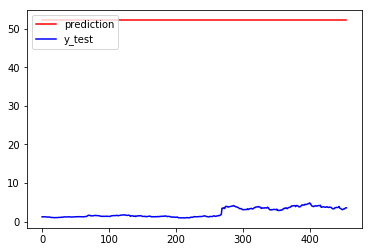

In [15]:
import matplotlib.pyplot as plt2

plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()